# Testing FOOOF with Synthetic Data

This notebook synthesizes synthetic power spectra, and tests FOOOF's performance on them.

In [1]:
%matplotlib inline
%load_ext autoreload

In [2]:
from collections import Counter

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from fooof import FOOOF, FOOOFGroup, fit_fooof_group_3d
from fooof.synth import gen_power_spectrum, gen_group_power_spectra

In [3]:
# Import project specific (local) custom code
%autoreload 2
from syn_utils import *
from syn_plts import *

In [4]:
# Set random seed
import random
random.seed(999)

In [5]:
sns.set_style('white')

## Check Generation

In [6]:
# Test generate a power spectrum
f_range = [2, 40]
bg = [0, 1]
osc = [10, 0.5, 2]
nlv = 0.
freq_res = 0.25

fs, ps = gen_power_spectrum(f_range, bg, osc, nlv, freq_res)

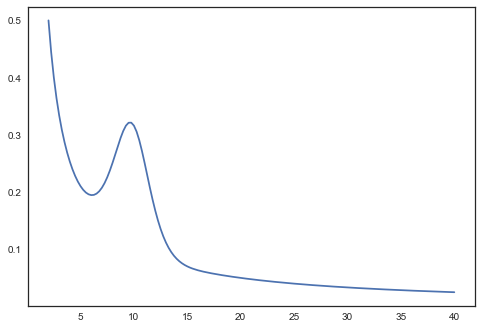

In [7]:
# Plot example synthesized power spectrum
plt.plot(fs, ps)

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 40 Hz                        
                                 Frequency Resolution is 0.25 Hz                                  
                                                                                                  
                             Background Parameters (offset, slope):                               
                                          0.0151, 1.0095                                          
                                                                                                  
                                       1 peaks were found:                                        
          

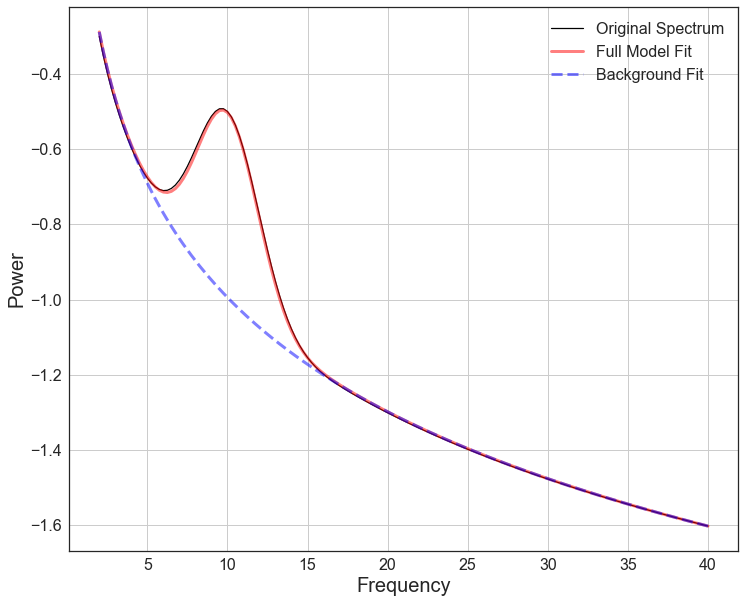

In [8]:
fm = FOOOF()
fm.report(fs, ps, plt_log=False)

In [9]:
# Compare actual parameters to FOOOF fit
print(bg, '\t', fm.background_params_)
print(osc, '\t', fm._gaussian_params)

[0, 1] 	 [ 0.01505844  1.00946517]
[10, 0.5, 2] 	 [[ 10.02088734   0.49164941   1.92918988]]


## Synthetic Generation Settings

Settings to be used in the synthetic generation are all defined in syn_utils. 

Here we will just check the settings that are being used. 

In [10]:
print_settings(N_OSCS_OPTS, N_OSCS_PROBS, '# of oscs')

Parameter definition for # of oscs 

	Value 	 Probability
	0 	 33.3%
	1 	 33.3%
	2 	 33.3%


In [11]:
print_settings(CF_OPTS, CF_PROBS, 'CFs')

Parameter definition for CFs 

	Value 	 Probability
	3 	 0.9%
	4 	 1.1%
	5 	 3.0%
	6 	 5.2%
	7 	 4.1%
	8 	 4.7%
	9 	 6.9%
	10 	 9.1%
	11 	 6.0%
	12 	 3.6%
	13 	 3.0%
	14 	 2.8%
	15 	 3.1%
	16 	 3.1%
	17 	 3.4%
	18 	 4.2%
	19 	 4.7%
	20 	 3.9%
	21 	 5.0%
	22 	 5.0%
	23 	 2.9%
	24 	 2.8%
	25 	 2.7%
	26 	 2.2%
	27 	 2.0%
	28 	 1.5%
	29 	 1.0%
	30 	 0.7%
	31 	 0.4%
	32 	 0.3%
	33 	 0.3%
	34 	 0.2%


In [12]:
print_settings(AMP_OPTS, AMP_PROBS, 'AMPs')

Parameter definition for AMPs 

	Value 	 Probability
	0.15 	 25.0%
	0.2 	 25.0%
	0.25 	 25.0%
	0.4 	 25.0%


In [13]:
print_settings(BW_OPTS, BW_PROBS, 'BWs')

Parameter definition for BWs 

	Value 	 Probability
	1.0 	 33.3%
	2.0 	 33.3%
	3.0 	 33.3%


In [14]:
print_settings(OFF_OPTS, OFF_PROBS, 'background offset')

Parameter definition for background offset 

	Value 	 Probability
	0 	 100.0%


In [15]:
print_settings(SL_OPTS, SL_PROBS, 'background slope')

Parameter definition for background slope 

	Value 	 Probability
	0.5 	 25.0%
	1 	 25.0%
	1.5 	 25.0%
	2 	 25.0%


In [16]:
# Sanity check probabilities are set correctly
for probs in [CF_PROBS, AMP_PROBS, BW_PROBS, OFF_PROBS, SL_PROBS]:
    assert np.isclose(sum(probs), 1, 1e-10)
print('All probabilities check out.')

All probabilities check out.


## Synthetic Fitting: One Peak Across Noise Levels

In [17]:
# Settings for PSD generation
f_range = [2, 40]
f_res = 0.25

# Set the number of PSDs - this is per noise condition
n_psds = 1000

# Set the noise levels to use
nlvs = [0.0, 0.025, 0.050, 0.10, 0.15]

# Use generators to sample peak & background parameters
peaks = gen_osc_def(1)
bgs = gen_bg_def()

In [18]:
# Get data sizes
n_nlvs = len(nlvs)
n_freqs = int((f_range[1] - f_range[0]) / f_res + 1)

In [19]:
# Generate power spectra
freqs = np.empty(shape=n_freqs)
psds = np.empty(shape=[n_nlvs, n_psds, n_freqs])
op_syn_params = [None] * n_nlvs

for n_ind, nlv in enumerate(nlvs):
    freqs, psds[n_ind, :, :], op_syn_params[n_ind] = gen_group_power_spectra(n_psds, f_range, bgs, peaks, nlv, f_res)
    
# Check shape
print('n_nlvs, n_spectra, n_freqs : ', psds.shape)

n_nlvs, n_spectra, n_freqs :  (5, 1000, 153)


In [20]:
# Extract ground truth values
osc_truths, bg_truths = get_ground_truth(op_syn_params)

##### Check the empirical levels of noise expected  (empirical noise floor)

These should be, and are, the same as the noise scaling factor. This just checks the estimate error on that, given the number of simulations. These values then set the amount of variance that can be expected to be captured by FOOOF - and if it captures more than this, we know that it is overfitting. 

In [21]:
emp_nlv = []
for nlv in nlvs:
    temp = []

    # Within each noise level, get the average squared 'error'
    for it in range(n_psds):
        temp.append(np.mean(np.random.normal(0, nlv, len(fs))**2))
    
    # Get the average 'error' per noise level
    emp_nlv.append(np.mean(temp))

# Compare simulated values to empirical values
print('NLVs :', nlvs)
print('EMP  :', np.sqrt(emp_nlv))

NLVs : [0.0, 0.025, 0.05, 0.1, 0.15]
EMP  : [ 0.          0.02501904  0.04992378  0.09970885  0.14998129]


In [22]:
# Initialize FOOOFGroup to test with
op_fg = FOOOFGroup(peak_width_limits=[1, 6], max_n_peaks=6)

# Print out settings used to syntethetic fitting - one peak
op_fg.print_settings()

                                                                                                  
                                         FOOOF - SETTINGS                                         
                                                                                                  
                                     Background Mode : fixed                                      
                                    Peak Width Limits : [1, 6]                                    
                                     Max Number of Peaks : 6                                      
                                     Minimum Amplitude : 0.0                                      
                                     Amplitude Threshold: 2.0                                     
                                                                                                  


In [23]:
# Fit power spectra - same FOOOF settings across each group of synthetic power spectra
op_fgs = fit_fooof_group_3d(op_fg, freqs, psds)

In [24]:
# # Alternatively:
# # Fit power spectra - adapting FOOOF settings for each group of synthetic power spectra
# fgs = []
# for nlv, nlv_psds in zip(nlvs, psds):
#     fg = FOOOFGroup(peak_width_limits=[1, 6], max_n_peaks=6, min_peak_amplitude=5*nlv)
#     fg.fit(freqs, nlv_psds)
#     fgs.append(fg.copy())

In [25]:
# Extract data of interest from FOOOF fits
osc_fits, bg_fits, err_fits, r2_fits, n_oscs = get_fit_data(op_fgs)

In [26]:
# Calculate error
osc_errors = np.abs(osc_truths - osc_fits) # absolute deviation
bg_errors = np.abs(bg_truths - bg_fits)

#osc_errors = (osc_truths - osc_fits)**2   # squared error
#bg_errors = (bg_truths - bg_fits)**2

In [27]:
# Pull out error per oscillations parameter
cf_errors = osc_errors[:, :, 0]
amp_errors = osc_errors[:, :, 1]
bw_errors = osc_errors[:, :, 2]

# Pull out error per background parameter
off_errors = bg_errors[:, :, 0]
sl_errors = bg_errors[:, :, 1]

In [28]:
# Plot Settings
#avg = 'mean'
#avg = 'median'
#err = 'sem'

save_fig = False

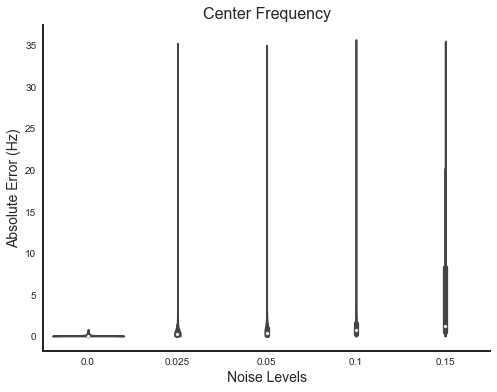

In [29]:
plot_errors_violin(cf_errors, 'Center Frequency', y_label='Absolute Error (Hz)',
                   save_fig=save_fig, save_name='1Peak-CF')

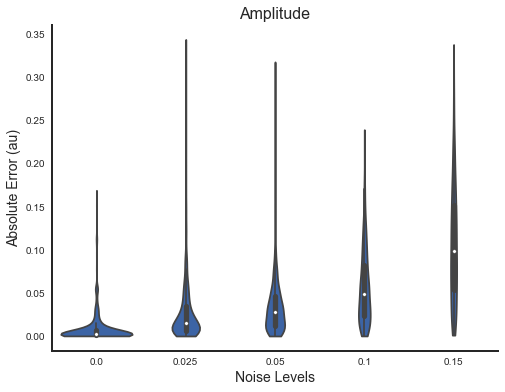

In [30]:
plot_errors_violin(amp_errors, 'Amplitude', y_label='Absolute Error (au)',
                   save_fig=save_fig, save_name='1Peak-Amp')

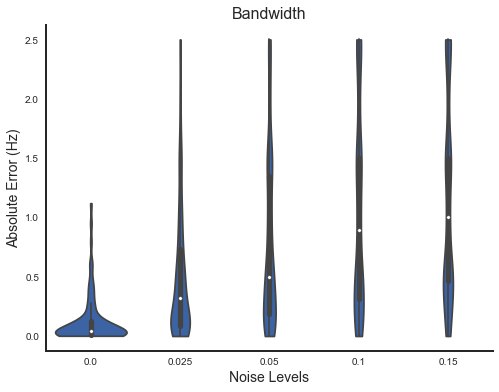

In [31]:
plot_errors_violin(bw_errors, 'Bandwidth', y_label='Absolute Error (Hz)',
                   save_fig=save_fig, save_name='1Peak-BW')

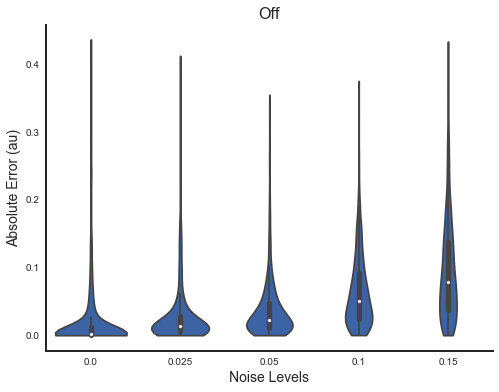

In [32]:
plot_errors_violin(off_errors, 'Off', y_label='Absolute Error (au)',
                   save_fig=save_fig, save_name='1Peak-Off')

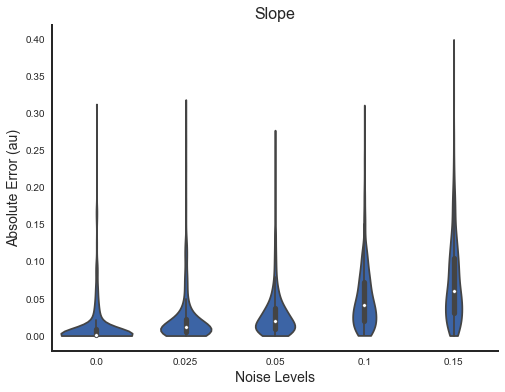

In [33]:
plot_errors_violin(sl_errors, 'Slope', y_label='Absolute Error (au)',
                   save_fig=save_fig, save_name='1Peak-Sl')

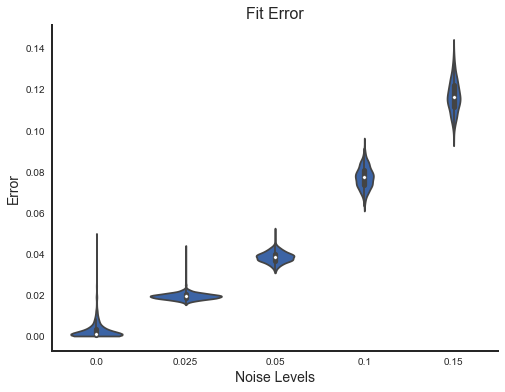

In [34]:
plot_errors_violin(err_fits, 'Fit Error', y_label='Error',
                   save_fig=save_fig, save_name='1Peak-Err')

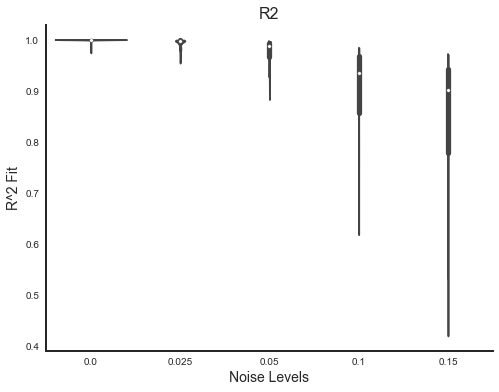

In [35]:
plot_errors_violin(r2_fits, 'R2', y_label='R^2 Fit',
                   save_fig=save_fig, save_name='1Peak-R2')

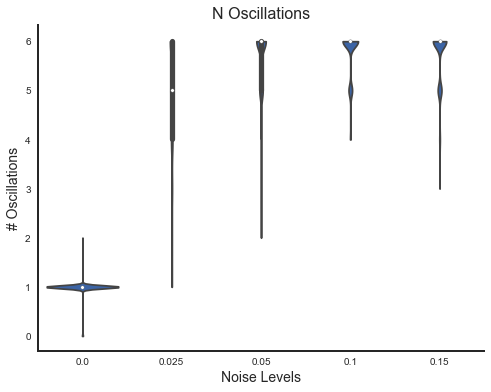

In [36]:
plot_errors_violin(n_oscs, 'N Oscillations', y_label='# Oscillations', 
                   save_fig=save_fig, save_name='1Peak_#Oscs')

In [37]:
# Explore fitting linear model across noise levels, checking the slope and fit error

# from scipy.stats import spearmanr
# from scipy.stats import linregress

# nlvs_cont = np.array([nlv * np.ones(shape=[1, 1000]) for nlv in nlvs]).flatten()
# temp = cf_errors.flatten()
# keep_inds = ~np.isnan(temp)

# slope, intercept, r_value, p_value, std_err = linregress(nlvs_cont[keep_inds],
#                                                          temp[keep_inds])
# print(r_value**2)

# Explore checking the correlation of median error with noise levels
# print(spearmanr(nlvs, np.nanmedian(cf_errors, 1)))

SynParams(background_params=[0, 1.0], gaussian_params=[[24, 0.20000000000000001, 3.0]], nlv=0.0)
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 40 Hz                        
                                 Frequency Resolution is 0.25 Hz                                  
                                                                                                  
                             Background Parameters (offset, slope):                               
                                         -0.0020, 0.9963                                          
                                                                                                  
            

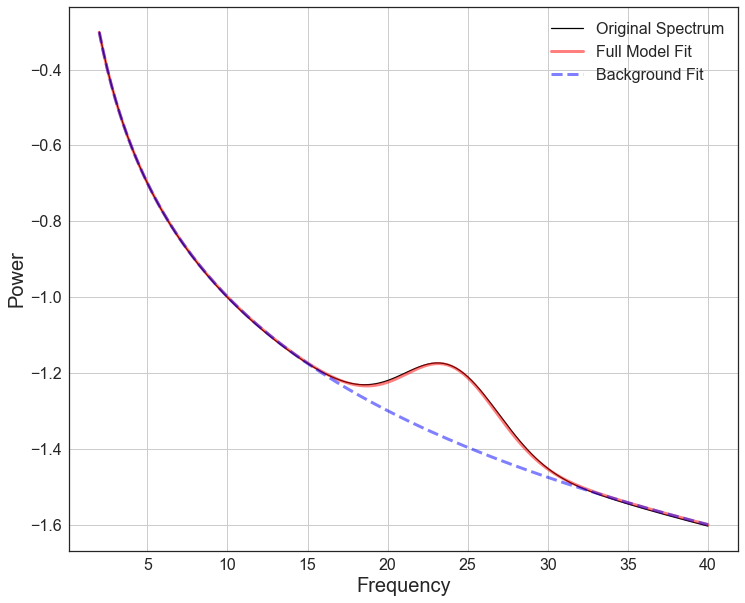

In [38]:
# Grab example cases - low noise
ind = 0
fm_nlv1 = op_fgs[0].get_fooof(ind, True)
print(op_syn_params[0][ind])
fm_nlv1.print_results()
fm_nlv1.plot(save_fig=True, file_name='1Peak-NLV1')

SynParams(background_params=[0, 0.5], gaussian_params=[[25, 0.25, 3.0]], nlv=0.15)
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 40 Hz                        
                                 Frequency Resolution is 0.25 Hz                                  
                                                                                                  
                             Background Parameters (offset, slope):                               
                                         -0.0783, 0.4756                                          
                                                                                                  
                          

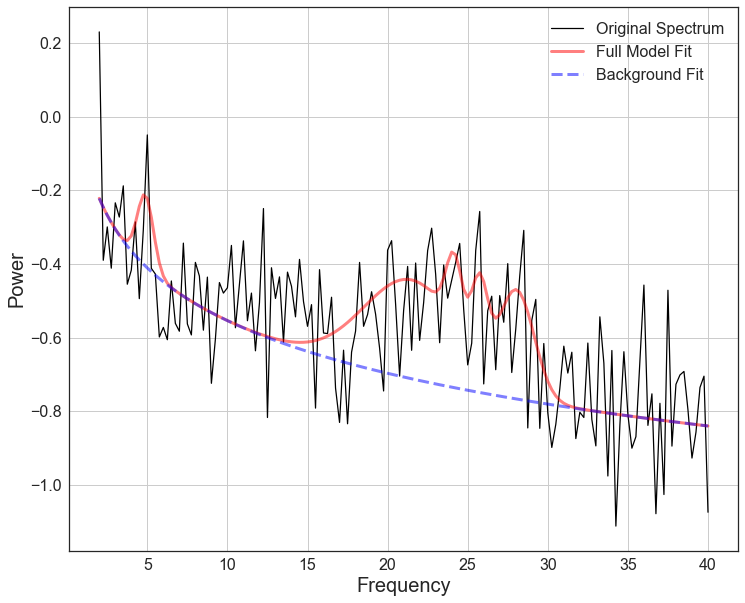

In [39]:
# Grab example cases - high noise
ind = 0
fm_nlv5 = op_fgs[-1].get_fooof(ind, True)
print(op_syn_params[-1][ind])
fm_nlv5.print_results()
fm_nlv5.plot(save_fig=True, file_name='1Peak-NLV5')

In [40]:
# Collect info for averages across all simulations
r2_fits_1p = r2_fits

## Synthetic Fitting: Multiple Peaks

In [41]:
# Settings for PSD generation
f_range = [2, 40]
f_res = 0.25

# Set the number of PSDs - this is per n_osc condition
n_psds = 1000

# Set the noise levels to use
n_oscs = [0, 1, 2, 3, 4]
nlv = 0.01
#nlvs = [0.0, 0.025, 0.050, 0.10, 0.15]

# Use generators to sample peak & background parameters
peaks = []
for n_osc in n_oscs:
    peaks.append(gen_osc_def(n_osc))
bgs = gen_bg_def()

In [42]:
# Get data sizes
n_n_oscs = len(n_oscs)
n_freqs = int((f_range[1] - f_range[0]) / f_res + 1)

In [43]:
# Generate power spectra
freqs = np.empty(shape=n_freqs)
psds = np.empty(shape=[n_n_oscs, n_psds, n_freqs])
mp_syn_params = [None] * n_n_oscs

#for n_ind, n_osc in enumerate(n_oscs):
for n_ind, n_osc, peaks in zip(range(n_n_oscs), n_oscs, peaks):
    freqs, psds[n_ind, :, :], mp_syn_params[n_ind] = gen_group_power_spectra(n_psds, f_range, bgs, peaks, nlv, f_res)
    
# Check shape
print('n_nlvs, n_spectra, n_freqs : ', psds.shape)

n_nlvs, n_spectra, n_freqs :  (5, 1000, 153)


In [44]:
# Extract ground truth values
peak_truths, bg_truths = get_ground_truth(mp_syn_params)

In [45]:
# Initialize FOOOFGroup to test with
mp_fg = FOOOFGroup(peak_width_limits=[1, 6], max_n_peaks=6, min_peak_amplitude=0.1)

# Check settings for FOOOF used to fit multiple peak simulations
mp_fg.print_settings()

                                                                                                  
                                         FOOOF - SETTINGS                                         
                                                                                                  
                                     Background Mode : fixed                                      
                                    Peak Width Limits : [1, 6]                                    
                                     Max Number of Peaks : 6                                      
                                     Minimum Amplitude : 0.1                                      
                                     Amplitude Threshold: 2.0                                     
                                                                                                  


In [46]:
# Fit power spectra - same FOOOF settings across each group of synthetic power spectra
mp_fgs = fit_fooof_group_3d(mp_fg, freqs, psds)

In [47]:
# Extract data of interest from FOOOF fits
_, bg_fits, err_fits, r2_fits, n_fit_oscs = get_fit_data(mp_fgs)

# Calculate error
bg_errors = np.abs(bg_truths - bg_fits)

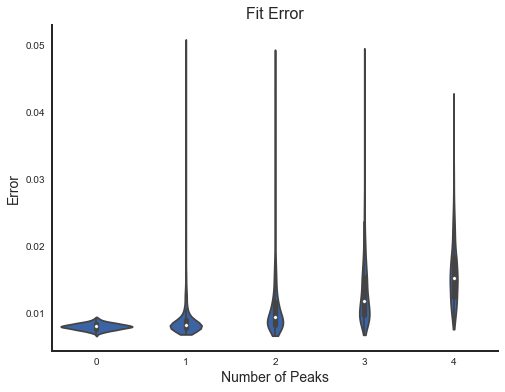

In [48]:
# Multi-peak fitting: plot 
plot_errors_violin(err_fits, 'Fit Error', x_axis='n_oscs', save_fig=True, save_name='MPeak-Err')

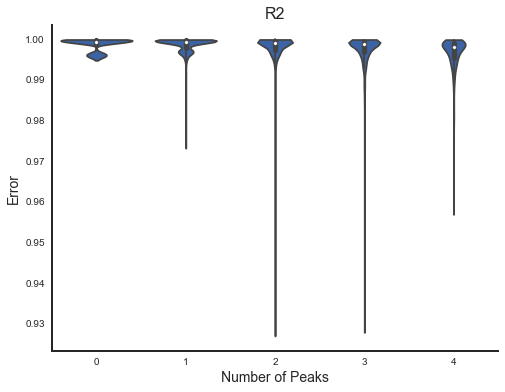

In [49]:
plot_errors_violin(r2_fits, 'R2', x_axis='n_oscs')

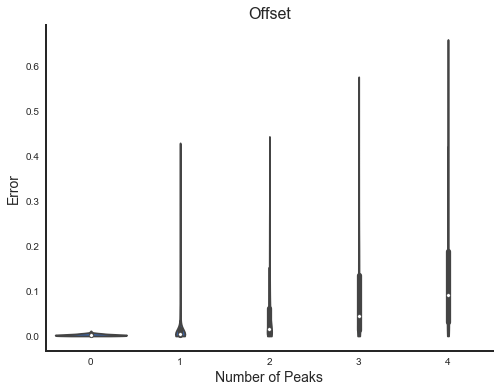

In [50]:
plot_errors_violin(bg_errors[:, :, 0], 'Offset', x_axis='n_oscs')

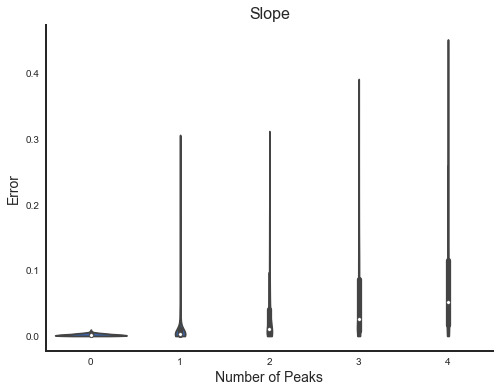

In [51]:
plot_errors_violin(bg_errors[:, :, 1], 'Slope', x_axis='n_oscs')

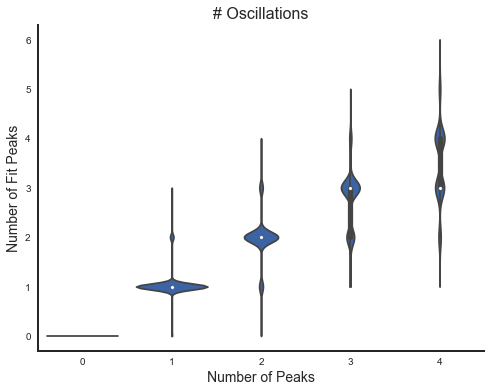

In [52]:
plot_errors_violin(n_fit_oscs, '# Oscillations', x_axis='n_oscs', y_label='Number of Fit Peaks')

In [53]:
# Grab all data for number of peaks simulated
n_actual_oscillations = []
for n in n_oscs:
    n_actual_oscillations.append([n] * n_psds)
n_actual_oscillations = np.array(n_actual_oscillations)
n_actual_oscillations = n_actual_oscillations.flatten()

# Grab data for number of peaks fit
n_fit_oscs = n_fit_oscs.flatten()

# Collect together # simulated & # fit, for plotting
dat = []
for a, b in zip(n_actual_oscillations, n_fit_oscs):
    dat.append((a, b))
n_osc_counter = Counter(dat)

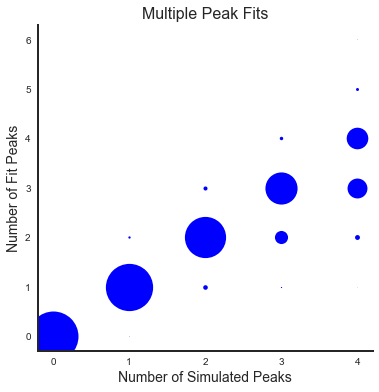

In [54]:
# Plot the correspondance between number of simulated peaks & number of fit peaks
plot_n_oscs_bubbles(n_osc_counter, True)

SynParams(background_params=[0, 0.5], gaussian_params=[[5, 0.14999999999999999, 1.0], [9, 0.40000000000000002, 3.0]], nlv=0.01)
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 40 Hz                        
                                 Frequency Resolution is 0.25 Hz                                  
                                                                                                  
                             Background Parameters (offset, slope):                               
                                          0.1205, 0.5800                                          
                                                                                

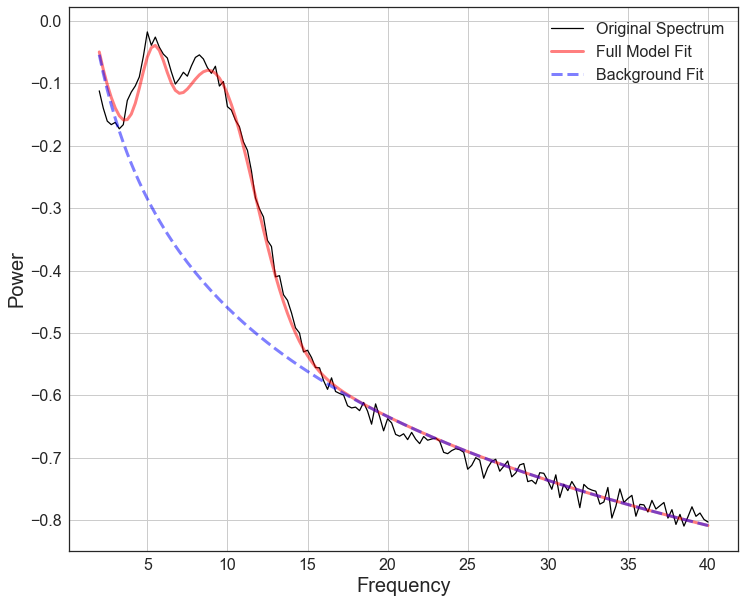

In [55]:
# Grab example case, plot & save out
ind = 1
fm = mp_fgs[2].get_fooof(ind, True)
print(mp_syn_params[2][ind])
fm.print_results()
fm.plot(save_fig=True, file_name='MultiPeak-2P')

SynParams(background_params=[0, 1.0], gaussian_params=[[6, 0.40000000000000002, 2.0], [13, 0.14999999999999999, 3.0], [19, 0.14999999999999999, 3.0], [26, 0.20000000000000001, 3.0]], nlv=0.01)
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 40 Hz                        
                                 Frequency Resolution is 0.25 Hz                                  
                                                                                                  
                             Background Parameters (offset, slope):                               
                                          0.2395, 1.1366                                          
               

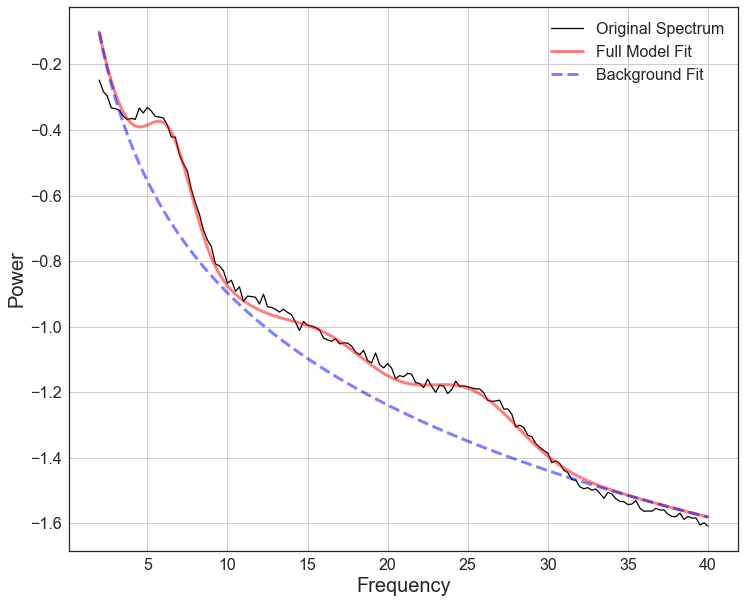

In [56]:
# Grab example case, plot & save out
ind = 10
fm = mp_fgs[-1].get_fooof(ind, True)
print(mp_syn_params[-1][ind])
fm.print_results()
fm.plot(save_fig=True, file_name='MultiPeak-4P')

In [57]:
## Check fit across all 10,000 simulations
temp = np.concatenate([r2_fits_1p.flatten(), r2_fits.flatten()])

print(np.min(temp), np.max(temp))
print(np.median(temp))

0.420449707985 0.999999988457
0.997204033687
